## General Setup

In [1]:
import math, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import SGD, RMSprop
from keras.utils import Sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow

Using TensorFlow backend.


In [2]:
np.random.seed(4096)
tensorflow.set_random_seed(4096)

In [3]:
EPOCHS = 250
INITIAL_LR = 0.001
BATCH_SIZE = 32

KERAS_MODEL_FILE = 'hist_classifier.h5'
TFLITE_MODEL_FILE = 'hist_classifier.tflite'
LABELS_FILE = 'hist_labels.pickle'

## Inspect Training Data

In [4]:
hist_df = pd.read_pickle('histograms.pickle')
hist_df.groupby('label').describe()

hull_proportion                                                    \
                    count      mean       std       min       25%       50%   
label                                                                         
black-cat           838.0  0.195105  0.093861  0.050582  0.124160  0.189468   
none               4873.0  0.002571  0.008531  0.000000  0.000000  0.000000   
other               364.0  0.649613  0.263468  0.058664  0.486754  0.656549   
ripley             2251.0  0.240641  0.102975  0.050432  0.159095  0.245237   

                               
                75%       max  
label                          
black-cat  0.242469  0.492666  
none       0.000000  0.049934  
other      0.895680  0.991091  
ripley     0.317009  0.499083

There is a significant class size imbalance, but in this case it should reduce the likelihood of our cat being mis-classified as the neigbors cat and squirted.

In [5]:
hist_df.sample(n=10)

,label,hull_proportion,fg_hist,bg_hist
155,ripley,0.282246,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000497265, 0.00994...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0005870267, 0.0333..."
3129,ripley,0.309680,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010231923, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00038476338, ..."
1796,ripley,0.130311,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.017881706, 0.05226...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0020666495, 0.0387..."
262,ripley,0.435706,"[0.0, 0.0, 0.0, 0.0, 0.011225444, 0.033052698,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.004571777, 0.03992..."
6651,none,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.016916968, 0.21525..."
3963,none,0.009686,"[0.0, 0.0, 0.0, 0.07480315, 0.05511811, 0.0314...","[0.0, 0.0, 0.0, 0.03113942, 0.16857749, 0.3408..."
2696,none,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0041195857, 0.1069..."
7987,black-cat,0.225217,"[0.0, 0.0, 0.0, 0.0, 0.18430826, 0.9916434, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.008315694, 0.01950..."
4756,none,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011495772, 0...."
2555,none,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010676916, ..."


Start by looking at a random sample of image histograms from different movement categories:

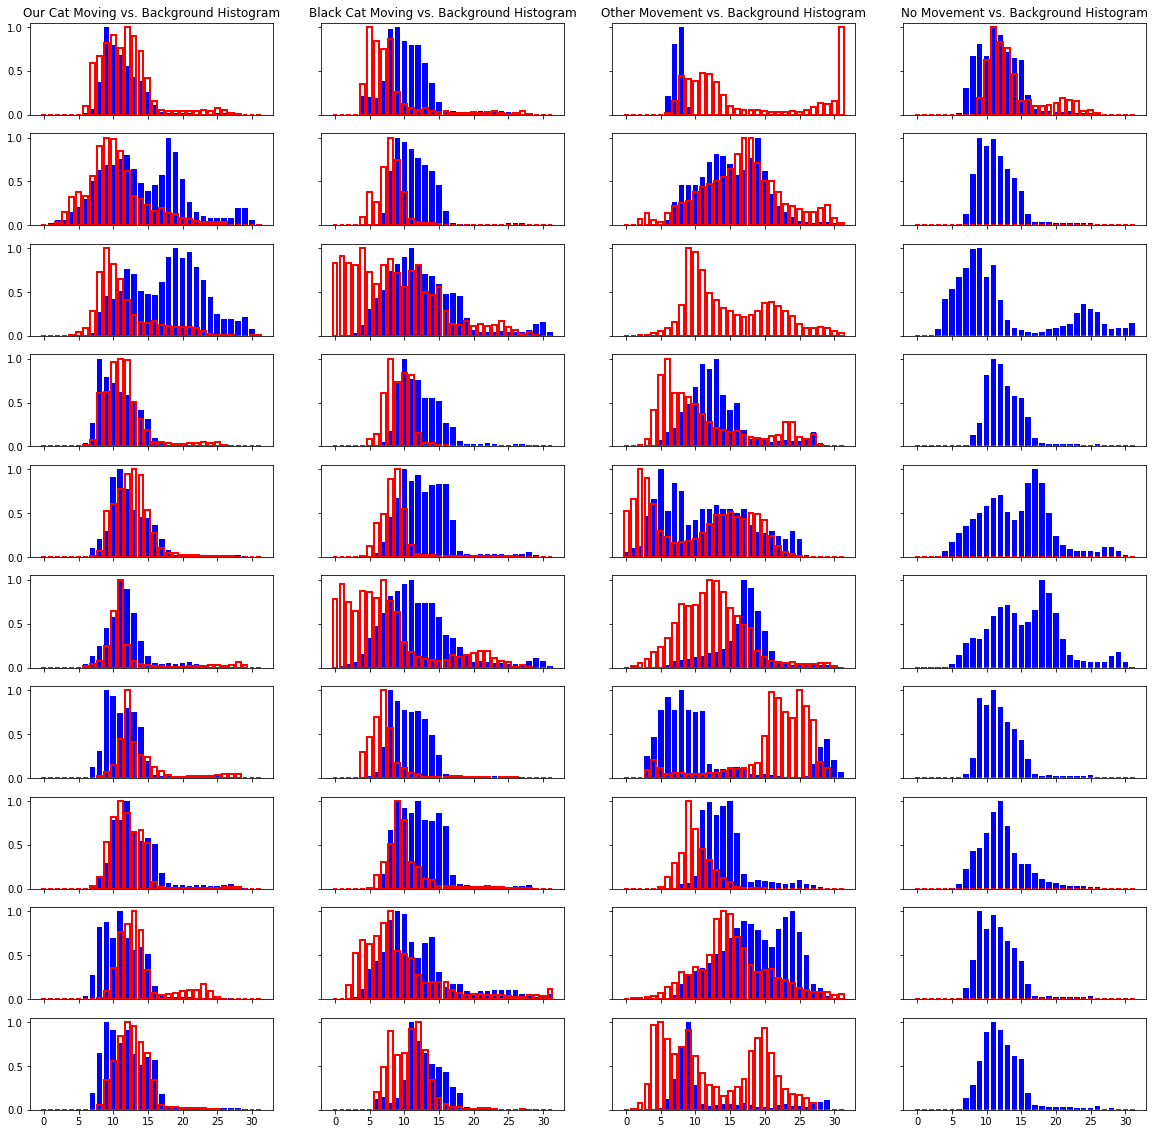

In [6]:
def plot_comparison(ax, row):
    xs = range(len(row.bg_hist.values[0]))
    ax.bar(xs, row.bg_hist.values[0], color='blue')
    ax.bar(xs, row.fg_hist.values[0], fill=False, edgecolor='red', width=0.7, linewidth=2)

N = 10

fig, axs = plt.subplots(N, 4, figsize=(20,2*N))

for index in range(0,N):
    row = hist_df[hist_df.label=='ripley'].sample()
    plot_comparison(axs[index,0], row)
    
    row = hist_df[hist_df.label=='black-cat'].sample()
    plot_comparison(axs[index,1], row)
    
    row = hist_df[hist_df.label=='other'].sample()
    plot_comparison(axs[index,2], row)
    
    row = hist_df[hist_df.label=='none'].sample()
    plot_comparison(axs[index,3], row)

axs[0,0].set_title('Our Cat Moving vs. Background Histogram')
axs[0,1].set_title('Black Cat Moving vs. Background Histogram')
axs[0,2].set_title('Other Movement vs. Background Histogram')
axs[0,3].set_title('No Movement vs. Background Histogram')

for ax in axs.flat:
    ax.label_outer()

plt.show()

Now compare the averaged histograms for each class:

Text(0.5, 1.0, 'No Movement')

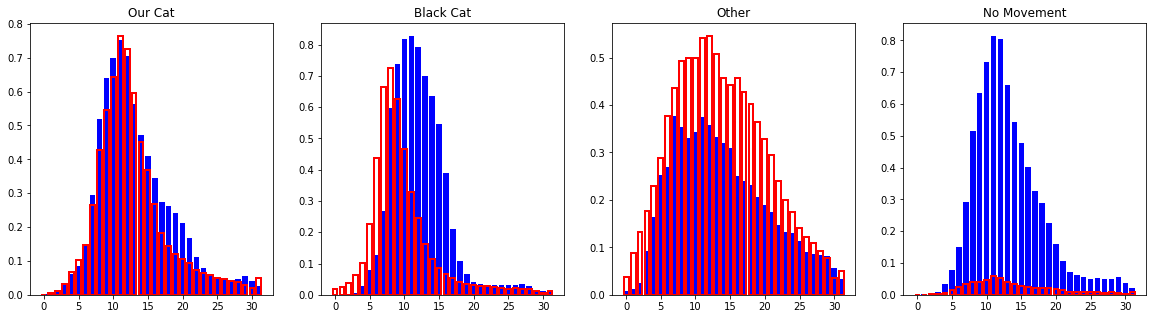

In [7]:
ripley_mean = hist_df[hist_df.label == 'ripley'].agg(['mean'])
black_cat_mean = hist_df[hist_df.label == 'black-cat'].agg(['mean'])
other_mean = hist_df[hist_df.label == 'other'].agg(['mean'])
none_mean = hist_df[hist_df.label == 'none'].agg(['mean'])

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

plot_comparison(axs[0], ripley_mean)
axs[0].set_title('Our Cat')

plot_comparison(axs[1], black_cat_mean)
axs[1].set_title('Black Cat')

plot_comparison(axs[2], other_mean)
axs[2].set_title('Other')

plot_comparison(axs[3], none_mean)
axs[3].set_title('No Movement')

The foreground histogram is generally darker (relative to the backround histogram) for the neighbors cat than it it for our cat, and the histograms for each class are significantly different.

It should be possible to differentiate between the cats based on these histograms.

We can also look at a scatter plot of the average foreground histogram value vs. average background histogram value for each class. Unfortunately, when we aggregate the data this way it becomes difficult to distinguish class:

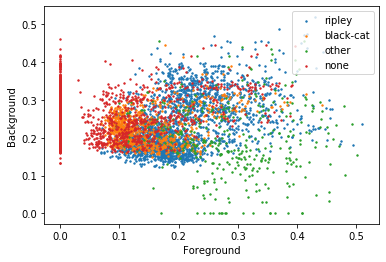

In [8]:
def scatter_for(label):
    df = hist_df[hist_df.label == label]
    xs = df.fg_hist.apply(np.mean)
    ys = df.bg_hist.apply(np.mean)
    plt.scatter(xs, ys, 2, label=label)

scatter_for('ripley')
scatter_for('black-cat')
scatter_for('other')
scatter_for('none')

plt.xlabel('Foreground')
plt.ylabel('Background')
plt.legend()

## Setup Image Generators

In [9]:
class HistSequence(Sequence):
    def __init__(self, df, labels, batch_size, mode='train'):
        self.df = df
        self.labels = labels
        self.batch_size = batch_size
        self.mode = mode
    
    def __len__(self):
        return int(math.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        i0 = self.batch_size * idx
        i1 = self.batch_size * (idx + 1)
        
        # Preprocess the histograms
        rows = self.df[i0:i1]
        stacked_hists = rows.apply(lambda row: np.hstack((row.hull_proportion, row.fg_hist, row.bg_hist)), axis=1)
        X = np.vstack(stacked_hists)

        # Preprocess the labels
        y = np.array(self.labels[i0:i1], np.float32)
        
        return X, y

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    hist_df,
    OneHotEncoder(sparse=False).fit_transform(hist_df.label.to_numpy().reshape(-1, 1)),
    test_size=0.2
)

train_seq = HistSequence(X_train, y_train, 32)
test_seq = HistSequence(X_test, y_test, 32, mode='test')

In [11]:
labels = sorted(hist_df.label.unique())

import pickle
with open(LABELS_FILE, 'wb') as f:
    pickle.dump(labels, f)

## Define Model

In [12]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(1+32+32,)),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 1,121,284
Trainable params: 1,121,284
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = SGD(lr=INITIAL_LR),
    metrics=['accuracy']
)

H = model.fit_generator(
    train_seq,
    validation_data=test_seq,
    steps_per_epoch=len(train_seq.df) / train_seq.batch_size,
    validation_steps=len(test_seq.df) / test_seq.batch_size,
    epochs=EPOCHS,
    callbacks=[
        ModelCheckpoint(KERAS_MODEL_FILE, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    ]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
209/208 [==============================] - 3s 14ms/step - loss: 1.3120 - acc: 0.4515 - val_loss: 1.1527 - val_acc: 0.5918

Epoch 00001: val_acc improved from -inf to 0.59184, saving model to hist_classifier.h5
Epoch 2/250
209/208 [==============================] - 3s 13ms/step - loss: 1.1050 - acc: 0.6271 - val_loss: 1.0117 - val_acc: 0.5882

Epoch 00002: val_acc did not improve from 0.59184
Epoch 3/250
209/208 [==============================] - 3s 13ms/step - loss: 0.9972 - acc: 0.6237 - val_loss: 0.9234 - val_acc: 0.5978

Epoch 00003: val_acc improved from 0.59184 to 0.59784, saving model to hist_classifier.h5
Epoch 4/250
209/208 [==============================] - 3s 13ms/step - loss: 0.9208 - acc: 0.6501 - val_loss: 0.8547 - val_acc: 0.6489

Epoch 00004: val_acc improved from 0.59784 to 0.64886, saving model to hist_classifier.h5
Epoch 5/250
209/208 [==============================] - 3s 13ms/step - loss: 0.8627 - acc: 0.689

## Export as TFLite Model

In [15]:
converter = tensorflow.contrib.lite.TFLiteConverter.from_keras_model_file(KERAS_MODEL_FILE)
converted_model = converter.convert()
with open(TFLITE_MODEL_FILE, 'wb') as f:
    f.write(converted_model)
    
keras.backend.clear_session()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.


## Evaluate Training Results

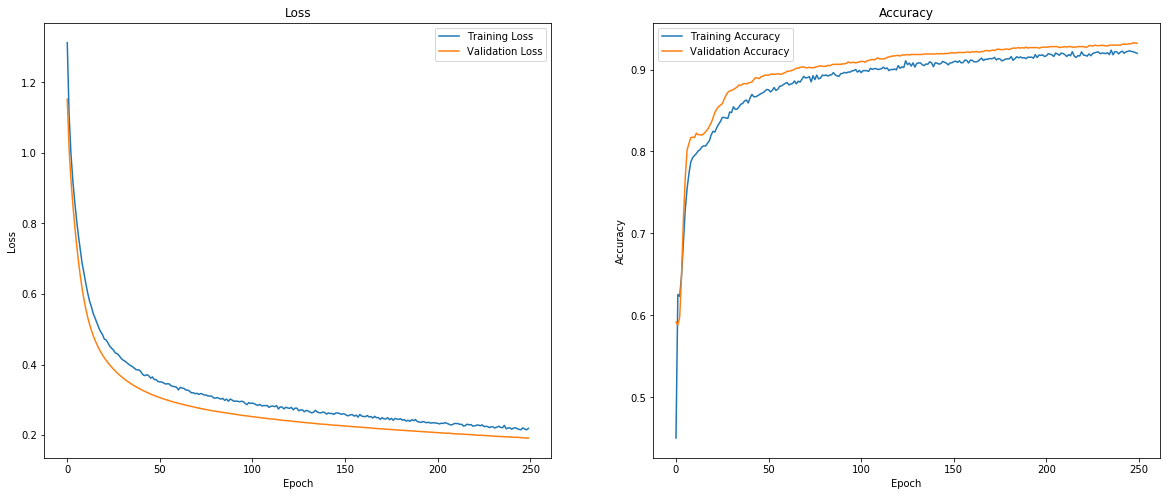

In [16]:
N = np.arange(0, EPOCHS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.plot(N, H.history["loss"], label="Training Loss")
ax1.plot(N, H.history["val_loss"], label="Validation Loss")
ax1.set(title="Loss", xlabel='Epoch', ylabel='Loss')
ax1.legend()

ax2.plot(N, H.history["acc"], label="Training Accuracy")
ax2.plot(N, H.history["val_acc"], label="Validation Accuracy")
ax2.set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax2.legend()

plt.show()